# Import Liberaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- **transforms:** Provides various transformation operations, such as resizing, normalizing, and data augmentation for images.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim

import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

# Define Global Varibales

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data"
train_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data/Training"
test_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data/Testing"
image_size = (224,224) # Image size
num_classes = 5
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [ ]:
device

'cuda'

# Applying Data Augumentation

### Data Transformations:
- **`train_transform`**:
  - Defines a series of transformations to be applied to training images, enhancing data variability and robustness:
    - **`RandomHorizontalFlip`**: Randomly flips the image horizontally.
    - **`RandomVerticalFlip`**: Randomly flips the image vertically.
    - **`RandomRotation(10)`**: Randomly rotates the image within a range of ±10 degrees.
    - **`Resize(image_size)`**: Resizes the image to the specified dimensions (224x224 pixels).
    - **`ToTensor`**: Converts the image to a PyTorch tensor, facilitating easy manipulation in neural networks.
    - **`Normalize`**: Normalizes the image tensor using predefined mean and standard deviation values for RGB channels, enhancing model convergence during training.

- **`test_transform`**:
  - Similar to `train_transform`, but without data augmentation techniques to ensure consistent input during evaluation:
    - **`Resize(image_size)`**: Resizes images to (224, 224).
    - **`ToTensor`**: Converts the image to a tensor.
    - **`Normalize`**: Normalizes the tensor using the same mean and standard deviation as the training set, ensuring that the test data is processed in the same way.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
- Custom `dataset` class inheriting from torch.utils.data.Dataset, which facilitates the loading and preprocessing of image data.
- Generates a list of labels corresponding to each image path.


In [ ]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}

    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        label_index = self.labels_to_index[label]

        if self.transform:
            img = self.transform(img)

        return img, label_index,label


    def __len__(self):
        return len(self.paths)


    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))


In [ ]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

# Data Splitting
- Splits the test dataset into validation and test datasets, with 50% of the data allocated to each.
- Uses a fixed random state (based on the ASCII value of "H") for reproducibility in the split.

In [ ]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display sample images with classes

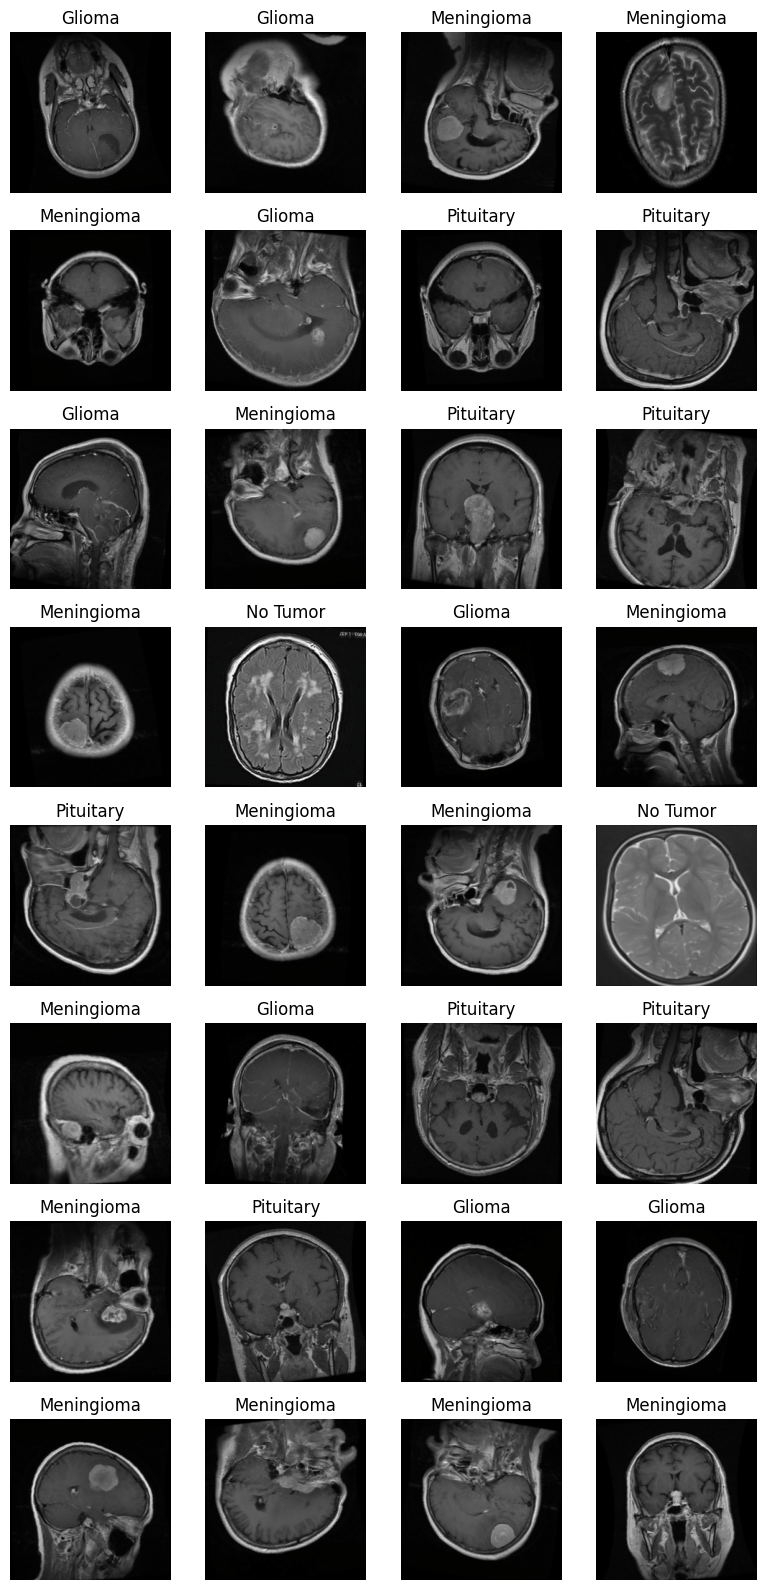

In [ ]:
train_iter = iter(train_loader)
images, labels_indices, labels = next(train_iter)

def imshow(input_images, labels_indices,labels):
    label_dict = {"notumor":"No Tumor", "glioma":"Glioma", "meningioma":"Meningioma","pituitary":"Pituitary"}
    input_images=input_images.numpy().transpose((0,2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    fig, axes = plt.subplots(8, 4, figsize=(8, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(input_images[i])
        ax.axis('off')
        ax.set_title(label_dict[labels[i]], fontsize=12)
    plt.tight_layout()
    plt.show()


imshow(images, labels_indices,labels)

# Custom Neural Network Model:
- **Purpose**: A convolutional neural network (CNN) for image classification.

#### Key Components:
- **Convolutional Layers**: Five layers (3 → 16 → 32 → 64 → 128 channels) with kernel size 4, no padding, and batch normalization.
- **Pooling**: Two Max Pooling layers to downsample features.
- **Fully Connected Layers**:
  - `fc1`: 512 neurons
  - `fc2`: Outputs class scores.
- **Activation**: ReLU used throughout.
- **Dropout**: 60% rate to reduce overfitting.
- **Flattening**: Converts 2D outputs to 1D for fully connected layers.

#### Forward Pass:
- Sequentially processes input through convolutional, normalization, pooling, flattening, and fully connected layers to generate class scores.

In [ ]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()

        self.conv1 = nn.Conv2d(3,16,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16,32,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn5 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6)

    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# class MyModel(nn.Module):
#     def __init__(self, num_classes):
#         super(MyModel, self).__init__()

#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0)
#         self.bn1 = nn.BatchNorm2d(32)

#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=0)
#         self.bn2 = nn.BatchNorm2d(64)

#         self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0)
#         self.bn3 = nn.BatchNorm2d(128)

#         self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
#         self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

#         # Update fc1 input size to match the flattened size
#         self.fc1 = nn.Linear(128 * 9 * 9, 512)  # Adjusted to 10368
#         self.fc2 = nn.Linear(512, num_classes)

#         self.flatten = nn.Flatten()
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.pool(x)
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = self.pool(x)
#         x = self.relu(self.bn3(self.conv3(x)))
#         x = self.pool2(x)

#         x = self.flatten(x)  # Flatten before fully connected layers
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


In [ ]:
model = MyModel(num_classes).to(device)

# Loss Function and Optimizer Setup


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

# Model Training

In [ ]:
def train_epoch():
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_predictions = 0

    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()

        loss.backward()
        optimizer.step()

        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions

    return avg_loss, avg_accuracy


In [ ]:
def eval_model():
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions

    return avg_loss, avg_accuracy


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#### Fitting the model

In [ ]:
best_score = float("inf")
n_epochs = 50
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()

    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)


Epoch 0,   

KeyboardInterrupt: 

# Evaluation

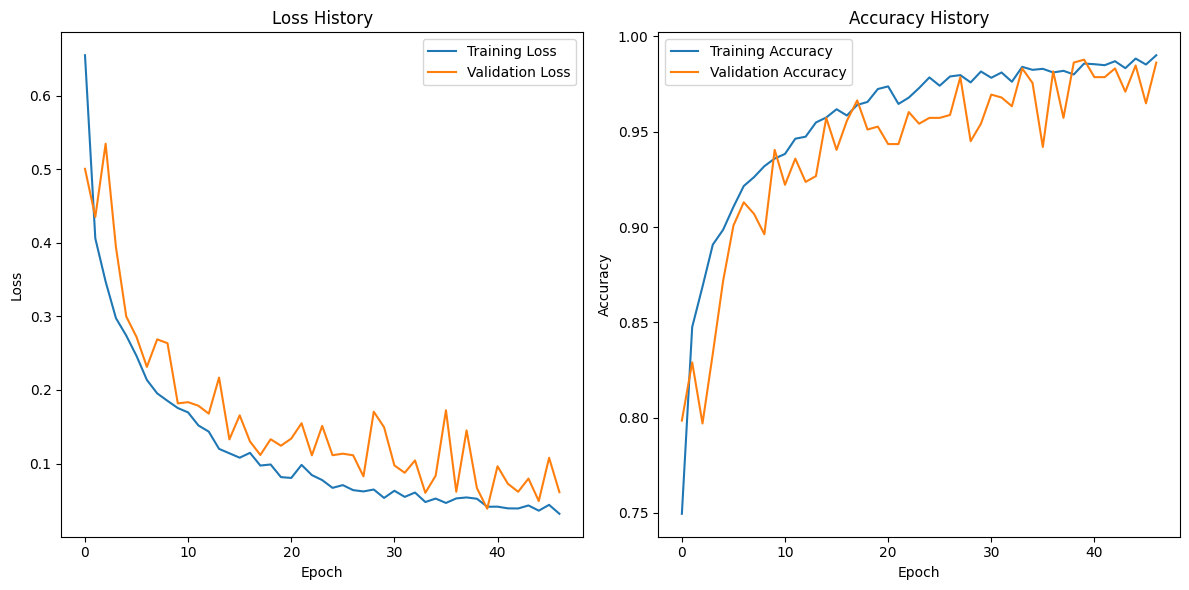

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

# Picking Best Model

In [ ]:
models = glob("/content/*")
print(models)
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "/content/model_" + str(sorted(model_num)[-1])
best_model_path

['/content/model_5', '/content/model_7', '/content/model_10', '/content/model_13', '/content/model_6', '/content/model_1', '/content/model_12', '/content/model_2', '/content/model_18', '/content/model_34', '/content/model_15', '/content/model_4', '/content/drive', '/content/model_23', '/content/model_40', '/content/model_17', '/content/model_28', '/content/sample_data']


'/content/model_40'

In [ ]:
best_model = MyModel(num_classes).to(device)

best_model.load_state_dict(torch.load("/content/drive/MyDrive/MetaViz/Paper/model_40", map_location=device))

<ipython-input-24-7412546293c5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("/content/drive/MyDrive/MetaViz/Paper/model_40", map_l

<All keys matched successfully>

# Prediction

In [ ]:
def predict(
    model:nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            predictions.append(y_pred.cpu().numpy())

    return np.vstack(predictions)

In [ ]:
best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

656

In [ ]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)

656

# Model Test Accuracy

In [ ]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 22.71%


# Confusion Matrix

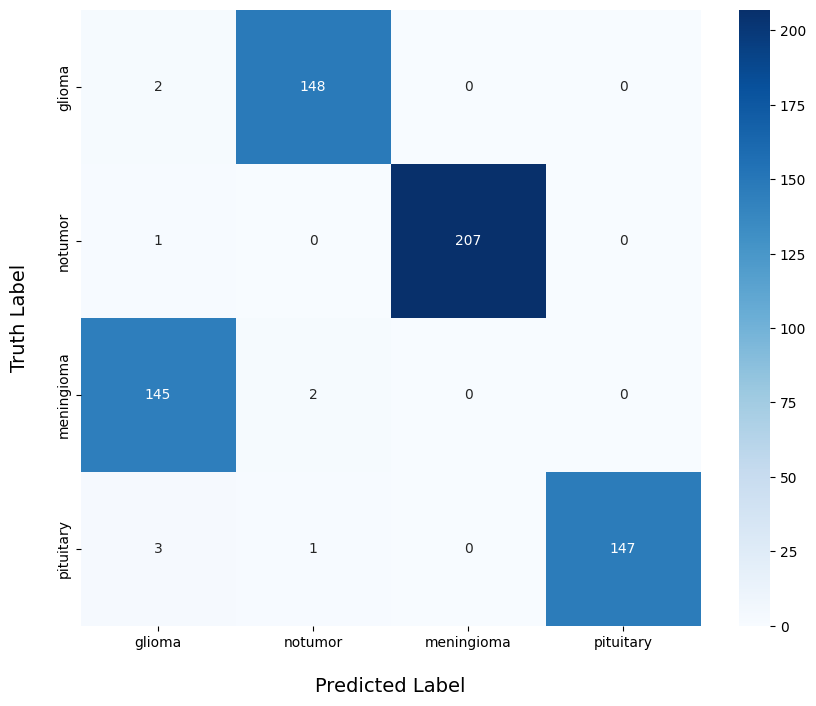

In [ ]:
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

# Inference

In [ ]:
# Imports
import torch
import torch.nn as nn

import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Model inference configuration
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/MetaViz/Paper/braintumor_model"  # Path to your saved model file
num_classes = 5
image_size = (224, 224)

# Define the model architecture (same as during training)
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(6 * 6 * 128, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the trained model
# model = MyModel(num_classes=num_classes).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()
# Load the trained model
model = MyModel(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


# Define the transformations
inference_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Label mapping
label_dict = {0: "Meningioma", 1: "Glioma", 2: "No Tumor", 3: "Pituitary"}

def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img = inference_transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(img)
        _, predicted_label = torch.max(output, 1)

    # Get the predicted label name
    label = label_dict[predicted_label.item()]
    return label

# Example usage
image_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data/Testing/pituitary/Te-piTr_0001.jpg"
predicted_label = predict_image(image_path)
print(f"The model predicts the image is: {predicted_label}")


<ipython-input-3-4e0dd6da22b9>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


The model predicts the image is: Pituitary


# Grad-CAM

In [ ]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s e

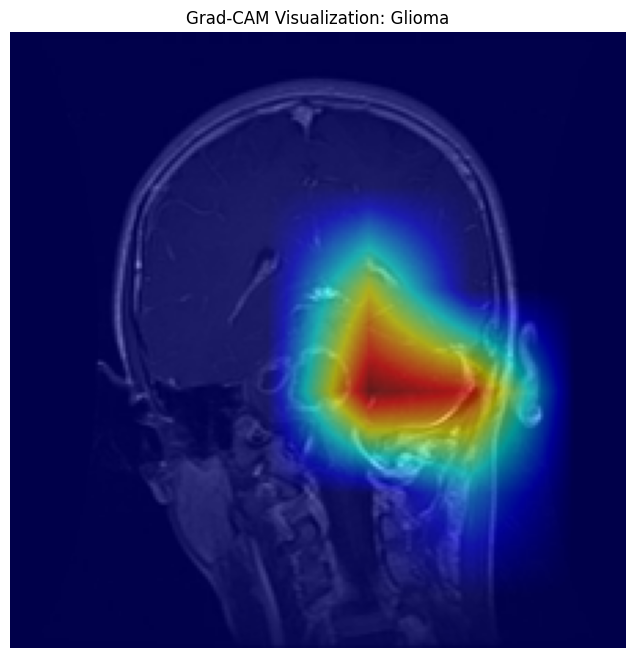

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import matplotlib.pyplot as plt

# Function to visualize Grad-CAM
def visualize_grad_cam(image_path, model, target_layer, label_dict):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img.resize(image_size)) / 255.0  # Resize and normalize to [0,1]
    img = inference_transform(img)
    input_tensor = img.unsqueeze(0).to(device)

    # Define the target (class index for Grad-CAM)
    target_index = None  # Set None if you want Grad-CAM for the predicted class
    with torch.no_grad():
        output = model(input_tensor)
        _, target_index = torch.max(output, 1)
        target_index = target_index.item()

    targets = [ClassifierOutputTarget(target_index)]

    # Create Grad-CAM object
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Generate the heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Resize the Grad-CAM heatmap to match the original image size
    grayscale_cam_resized = cv2.resize(grayscale_cam, (image_size[1], image_size[0]))

    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(img_np, grayscale_cam_resized, use_rgb=True)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f"Grad-CAM Visualization: {label_dict[target_index]}")
    plt.show()

# Specify the target layer for Grad-CAM (last convolutional layer)
target_layer = model.conv4

# Path to the input image
image_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data/Training/glioma/Tr-glTr_0003.jpg"

# Visualize Grad-CAM
visualize_grad_cam(image_path, model, target_layer, label_dict)


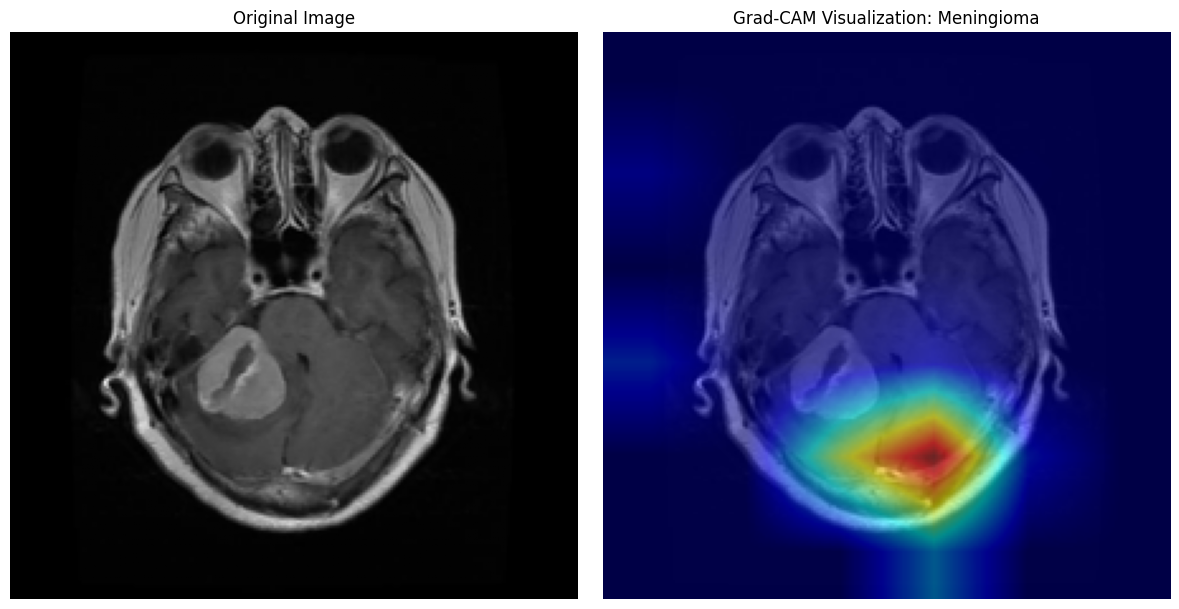

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Function to visualize Grad-CAM
def visualize_grad_cam(image_path, model, target_layer, label_dict, image_size=(224, 224)):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_resized = img.resize(image_size)  # Resize to match the model's input size
    img_np = np.array(img_resized) / 255.0  # Convert to numpy array and normalize to [0, 1]

    # Transform for inference (modify this as per your model's preprocessing)
    img_tensor = inference_transform(img_resized)
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # Define the target (class index for Grad-CAM)
    with torch.no_grad():
        output = model(input_tensor)
        _, target_index = torch.max(output, 1)
        target_index = target_index.item()

    targets = [ClassifierOutputTarget(target_index)]

    # Create Grad-CAM object
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Generate the heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Resize the Grad-CAM heatmap to match the original image size
    grayscale_cam_resized = cv2.resize(grayscale_cam, (image_size[1], image_size[0]))

    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(img_np, grayscale_cam_resized, use_rgb=True)

    # Plot the original image and Grad-CAM visualization side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Original Image")

    # Grad-CAM visualization
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f"Grad-CAM Visualization: {label_dict[target_index]}")

    plt.tight_layout()
    plt.show()

# Specify the target layer for Grad-CAM (last convolutional layer)
target_layer = model.conv4

# Path to the input image
image_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data/Training/glioma/Tr-glTr_0003.jpg"

# Visualize Grad-CAM
visualize_grad_cam(image_path, model, target_layer, label_dict)


# LIME

In [ ]:
!pip install lime

In [ ]:
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Define preprocessing (resize and normalize)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the model's expected dimensions
    transforms.ToTensor()          # Convert image to PyTorch tensor
])
img = Image.open(image_path).convert("RGB")
image_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

def model_predict(images):
    """
    Converts images to tensors, resizes them, and passes through the model.
    """
    preprocessed_images = []
    for img in images:
        # Resize and preprocess each image
        img_tensor = preprocess(Image.fromarray(img))
        preprocessed_images.append(img_tensor)

    # Stack images into a batch
    images_tensor = torch.stack(preprocessed_images).to(device)

    # Get model predictions
    with torch.no_grad():
        logits = model(images_tensor)
        probabilities = F.softmax(logits, dim=1)

    return probabilities.cpu().numpy()

from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Create a LIME explainer
explainer = LimeImageExplainer()

# Preprocess the image for LIME
image_path = "/content/drive/MyDrive/MetaViz/Paper/brain_tumor_data/Training/notumor/Tr-noTr_0003.jpg"
img = Image.open(image_path).convert("RGB")
original_image = np.array(img)

# Explain the model's prediction for this image
explanation = explainer.explain_instance(
    original_image,             # The input image
    model_predict,              # Your model's prediction function
    top_labels=3,               # Number of top labels to explain
    hide_color=0,               # Color to hide superpixels (if any)
    num_samples=1000            # Number of perturbations
)


  0%|          | 0/1000 [00:00<?, ?it/s]

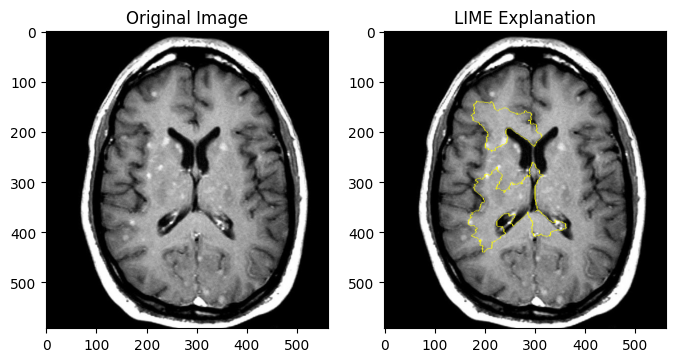

In [ ]:
# Visualize explanation for the top predicted label
from skimage.color import label2rgb

# Get the label with the highest probability
top_label = explanation.top_labels[0]

# Get the image and mask for the explanation
temp, mask = explanation.get_image_and_mask(
    label=top_label,            # Label to explain
    positive_only=True,         # Show only features that contribute positively
    num_features=10,            # Number of superpixels to show
    hide_rest=False             # Hide other parts of the image
)

# Display the original image and explanation
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.show()


#SHAP

In [ ]:
pip install --upgrade shap

In [ ]:
import shap

In [ ]:
test_iter = iter(test_loader)
images, labels_indices, labels = next(test_iter)

images[0].shape

NameError: name 'test_loader' is not defined

In [ ]:
labels

('meningioma',
 'pituitary',
 'meningioma',
 'pituitary',
 'meningioma',
 'pituitary',
 'meningioma',
 'notumor',
 'meningioma',
 'pituitary',
 'meningioma',
 'glioma',
 'glioma',
 'glioma',
 'glioma',
 'glioma',
 'meningioma',
 'pituitary',
 'glioma',
 'pituitary',
 'pituitary',
 'notumor',
 'glioma',
 'notumor',
 'notumor',
 'pituitary',
 'meningioma',
 'glioma',
 'notumor',
 'meningioma',
 'glioma',
 'meningioma')

torch.Size([32, 3, 224, 224])
(1, 3, 224, 224)


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.57s/it]               


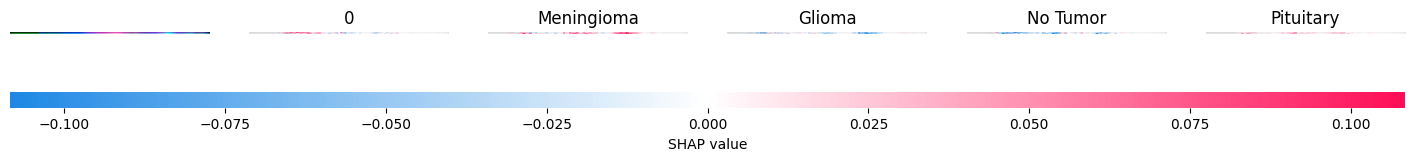

In [ ]:
import torch
import shap

# Example data loading
test_iter = iter(test_loader)
images, labels_indices, labels = next(test_iter)
print(images.shape)  # Should be [32, 3, 224, 224]

# Define a model function
def f(x):
    # Ensure x is converted to a torch.Tensor for the model
    x = torch.tensor(x, dtype=torch.float32).to(next(model.parameters()).device)  # Ensure correct device
    return model(x).detach().cpu().numpy()  # Return numpy array for SHAP

# Initialize the masker with the correct shape
masker_blur = shap.maskers.Image("blur(32,32)", images[2].shape)

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=list(range(5)))

# Add a batch dimension to images[0]
image_batch = images[2].unsqueeze(0).numpy()  # Shape becomes (1, 3, 224, 224)
print(image_batch.shape)
# Calculate SHAP values
shap_values_ = explainer(image_batch, max_evals=5000, batch_size=50)

# Plot the SHAP values
shap.image_plot(shap_values_, labels=[0, "Meningioma", "Glioma", "No Tumor", "Pituitary"])


In [ ]:
import shap

# Create a SHAP explainer
def pytorch_predict(model, images):
    model.eval()
    outputs = model(images)
    return outputs.detach().numpy()

explainer = shap.Explainer(pytorch_predict, model)

In [ ]:
# Get a batch of images from the test loader
test_iter = iter(test_loader)
images, labels_indices, labels = next(test_iter)
images.shape
# Generate SHAP values


torch.Size([32, 3, 224, 224])

In [ ]:
device = torch.device('cpu')

# Move the model to the CPU
model = model.to(device)
explainer = shap.GradientExplainer(model, [timages])

In [ ]:
test_iter = iter(test_loader)
images, labels_indices, labels = next(test_iter)
print(len(images))
shap_values = explainer.shap_values([images[:6]])


32


In [ ]:
labels[:6]

('meningioma',
 'pituitary',
 'meningioma',
 'pituitary',
 'meningioma',
 'pituitary')

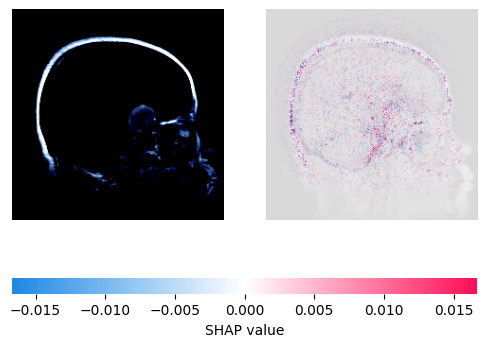

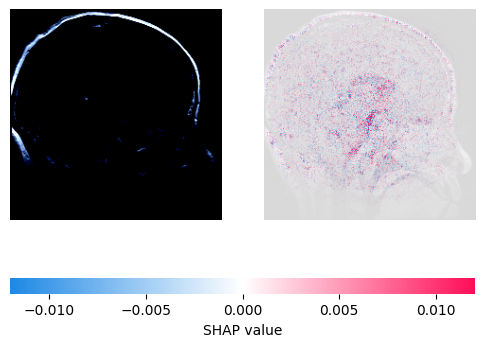

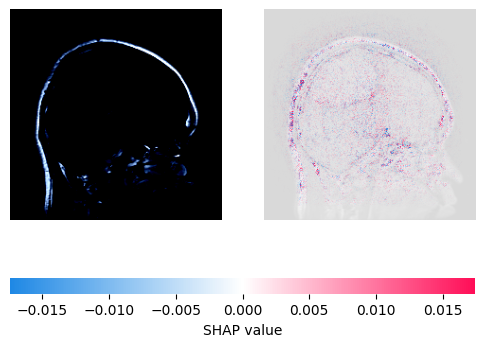

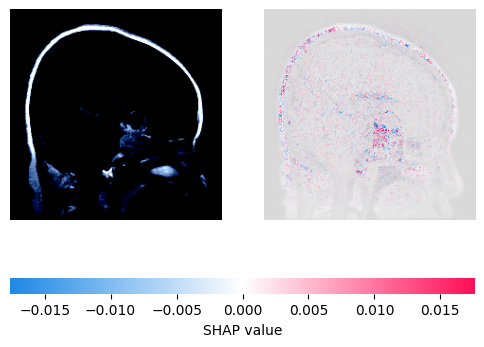

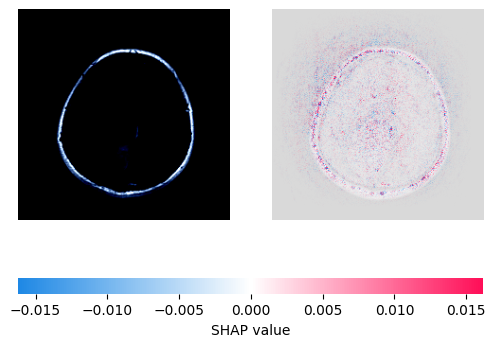

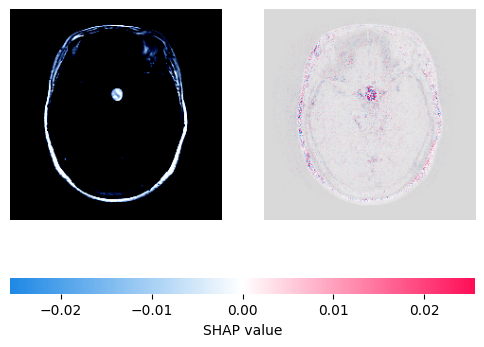

In [ ]:
for i in range(6):
    shap.image_plot([shap_values[i][0]], np.transpose(images[i].cpu().numpy(), (1, 2, 0)))

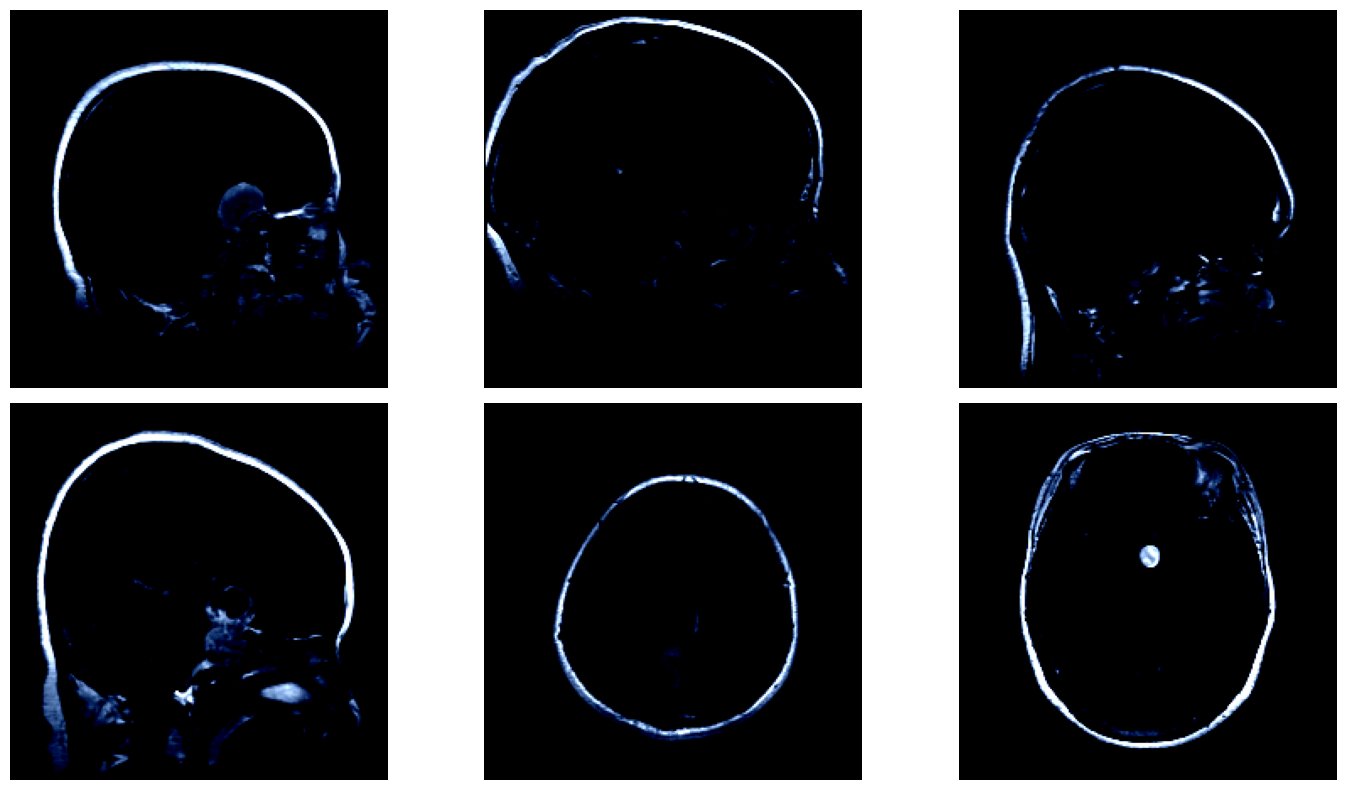

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    ax.axis('off')
plt.tight_layout()
plt.show()